In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision import models
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from monai.losses import DiceLoss
from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import copy
from copy import deepcopy
import cv2
import sys
import os
import pandas as pd
import numpy as np
import random
from pathlib import Path
import math
# from evaluation import *

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # dead kernel for matplotlib

In [3]:
print(sys.path)

['D:\\Doby\\OMS\\segmentation inference', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\python311.zip', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\DLLs', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby', '', 'C:\\Users\\GAONNURI\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib\\site-packages', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib\\site-packages\\win32', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib\\site-packages\\Pythonwin']


In [4]:
sys.path.append('../segmentation')

In [5]:
print(sys.path)

['D:\\Doby\\OMS\\segmentation inference', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\python311.zip', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\DLLs', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby', '', 'C:\\Users\\GAONNURI\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib\\site-packages', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib\\site-packages\\win32', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\GAONNURI\\anaconda3\\envs\\doby\\Lib\\site-packages\\Pythonwin', '../segmentation']


In [6]:
from SA_UNet import SA_UNet

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
metadata = pd.read_csv('../doby_meta.csv')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7064 entries, 0 to 7063
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject_id      7064 non-null   int64 
 1   study_id        7064 non-null   int64 
 2   dicom_id        7064 non-null   object
 3   DicomPath       7064 non-null   object
 4   edema_severity  7064 non-null   int64 
 5   normal          7064 non-null   int64 
 6   CHF             7064 non-null   bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 338.2+ KB


In [9]:
metadata = metadata[metadata['subject_id'] < 16000000]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4198 entries, 0 to 4197
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject_id      4198 non-null   int64 
 1   study_id        4198 non-null   int64 
 2   dicom_id        4198 non-null   object
 3   DicomPath       4198 non-null   object
 4   edema_severity  4198 non-null   int64 
 5   normal          4198 non-null   int64 
 6   CHF             4198 non-null   bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 233.7+ KB


In [10]:
SEG_BASE_PATH = '../chest-x-ray-dataset-with-lung-segmentation-1.0.0/chest-x-ray-dataset-with-lung-segmentation-1.0.0'
ORIG_BASE_PATH = '../physionet.org/files/mimic-cxr-jpg/2.0.0'

In [11]:
TRAIN_TRANSFORMS = transforms.Compose([
    transforms.ToTensor()
])

TARGET_TRANSFORMS = transforms.Compose([
    transforms.ToTensor()
])

In [12]:
class Dataset(Dataset):
    def __init__(self, metadata, mask_base_path, orig_base_path, transform=None, target_transform=None):
        self.metadata = metadata
        self.base_path = Path(orig_base_path)
        self.mask_path = Path(mask_base_path)
        
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self, idx):
        detail_path = self.metadata.loc[idx, 'DicomPath']
        y_path = self.mask_path / Path(str(detail_path[:-4]) + '-mask.jpg')
        x_path = self.base_path / Path(str(detail_path))

        y = Image.open(str(y_path))
        x = cv2.imread(str(x_path), cv2.IMREAD_GRAYSCALE)
        x = cv2.resize(x, dsize=(224, 224), interpolation=cv2.INTER_AREA)

        del detail_path
        del y_path
        del x_path

        # 이것 때문인지는 모르겠는데 ToTensor로 Normalize가 안 된다.
        # y = np.where(y > 128, 255, 0) # 128 threshold
        # y = np.where(y > 128, 255, 0) / 255.
        
        if self.transform:
            x = self.transform(x)

        if self.target_transform:
            y = self.target_transform(y)

        return x, y

    def __len__(self):
        return self.metadata['normal'].count()

In [13]:
ds = Dataset(metadata, 
             SEG_BASE_PATH, 
             ORIG_BASE_PATH,
             transform=TRAIN_TRANSFORMS,
             target_transform=TARGET_TRANSFORMS)

In [14]:
ds_size = len(ds)
train_size = int(ds_size * 0.8)
test_size = ds_size - train_size
train_ds, test_ds = random_split(ds, [train_size, test_size], generator=torch.manual_seed(42))

In [15]:
test_dl = DataLoader(test_ds, batch_size=8, shuffle=True)

In [16]:
model = SA_UNet(channel=1, block_size=5) # feature size 10%
model.load_state_dict(torch.load('../segmentation/parameters/sa_unet_best_acc_model_state.pt'))
model.to(device)

SA_UNet(
  (e1): EncoderBlock(
    (convBlk): ConvBlock(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop1): DropBlock()
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop2): DropBlock()
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncoderBlock(
    (convBlk): ConvBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop1): DropBlock()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [17]:
model2 = SA_UNet(channel=1, block_size=5)
model2.load_state_dict(torch.load('../segmentation/parameters/sa_unet_best_f1_model_state.pt'))
model2.to(device)

SA_UNet(
  (e1): EncoderBlock(
    (convBlk): ConvBlock(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop1): DropBlock()
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop2): DropBlock()
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncoderBlock(
    (convBlk): ConvBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop1): DropBlock()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [18]:
loss_fn = DiceLoss(reduction='mean').to(device)

In [36]:
def test(model, data_loader):
    model.eval()
    test_acc = 0
    test_loss = 0
    n_data = 0
    TP, FP, TN, FN = 0, 0, 0, 0
    output_pixels = 0
    pre = []
    tar = []
    
    with torch.no_grad():
        for batch, target in data_loader:
            batch, target = batch.to(device), target.to(device)

            output = model(batch)

            output_flat = output.view(output.size(0), -1)
            target_flat = target.view(target.size(0), -1)
            temp_pre = output.cpu().detach().numpy()
            pre.append(temp_pre)
            temp_tar = target.cpu().detach().numpy()
            tar.append(temp_tar)

            loss = loss_fn(output_flat, target_flat)
            test_loss += loss.item()

            output_flat = (output_flat >= torch.FloatTensor([0.5]).to(device)).type(torch.float32)

            correct = (output_flat == target_flat).sum().item()
            test_acc += correct

            TP += ((output_flat == target_flat) & (target_flat == 1)).sum().item()
            FP += ((output_flat != target_flat) & (target_flat == 0)).sum().item()
            TN += ((output_flat == target_flat) & (target_flat == 0)).sum().item()
            FN += ((output_flat != target_flat) & (target_flat == 1)).sum().item()
            
            n_data += len(batch)
            output_pixels = (output_flat.shape[1])
            
            print(f'\rTest set: [{100*n_data/len(data_loader.dataset):.2f}%]', end='')
    
    test_acc = 100 * test_acc / (len(data_loader.dataset)*output_pixels)
    test_loss = test_loss / len(data_loader)
    
    print(f'\rTest set: Accuracy: {test_acc:.2f}%  Loss: {test_loss:.4f}')

    return test_acc, test_loss, TP, FP, TN, FN, pre, tar

In [37]:
def getMetric(TP, FP, TN, FN):
    # base case: divide by zero
    TP = 0.1 if TP == 0 else TP
    FP = 0.1 if FP == 0 else FP
    TN = 0.1 if TN == 0 else TN
    FN = 0.1 if FN == 0 else FN
    
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*precision*recall/(precision+recall)
    mcc = ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    
    return sensitivity, specificity, f1_score, mcc

In [38]:
acc, loss, tp, fp, tn, fn, pre, tar = test(model, test_dl)
sensitivity, specificity, f1_score, mcc = getMetric(tp, fp, tn, fn)
print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')
print(f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}\nF1-Score: {f1_score:.4f}, MCC: {mcc:.4f}')

Test set: Accuracy: 93.85%  Loss: 0.0419
TP: 11340521, FP: 326872, TN: 28216334, FN: 471018
Sensitivity: 0.9601, Specificity: 0.9885
F1-Score: 0.9660, MCC: 0.9521


AUC: 0.9613


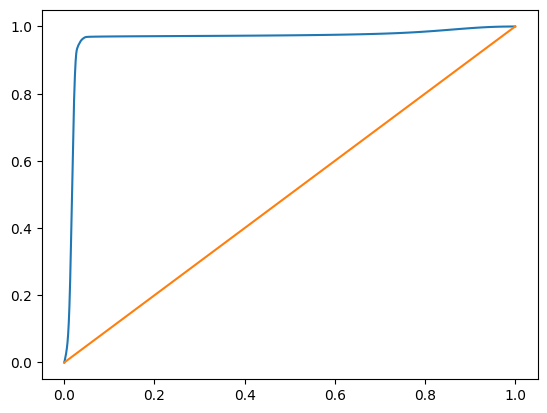

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

pre = np.array(pre).flatten()
tar = np.array(tar, dtype=np.uint8).flatten()
fpr, tpr, thresholds = roc_curve(tar, pre)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
print(f'AUC: {roc_auc_score(tar, pre):.4f}')

In [46]:
np.save('./target_and_predict/sa_unet_5_acc_tar', tar)
np.save('./target_and_predict/sa_unet_5_acc_pre', pre)

In [47]:
acc, loss, tp, fp, tn, fn, pre, tar = test(model, test_dl)
sensitivity, specificity, f1_score, mcc = getMetric(tp, fp, tn, fn)
print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')
print(f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}\nF1-Score: {f1_score:.4f}, MCC: {mcc:.4f}')

Test set: Accuracy: 93.85%  Loss: 0.0420
TP: 11340521, FP: 326872, TN: 28216334, FN: 471018
Sensitivity: 0.9601, Specificity: 0.9885
F1-Score: 0.9660, MCC: 0.9521


AUC: 0.9613


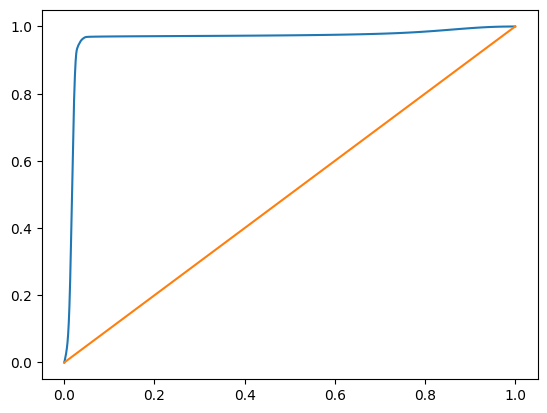

In [48]:
pre = np.array(pre).flatten()
tar = np.array(tar, dtype=np.uint8).flatten()
fpr, tpr, thresholds = roc_curve(tar, pre)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
print(f'AUC: {roc_auc_score(tar, pre):.4f}')

In [49]:
np.save('./target_and_predict/sa_unet_5_f1_tar', tar)
np.save('./target_and_predict/sa_unet_5_f1_pre', pre)